In [1]:
import torch
import torch.nn as nn
import cv2
from model_util import convbnrelu,image_CBR_2,image_CBR_3,depth_CBR_2,depth_CBR_3
import numpy as np
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def read_image(path):
    img = cv2.imread(path)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img

def load_sparse_depth(input_sparse_depth_fp):
    input_sparse_depth = np.array(Image.open(input_sparse_depth_fp), dtype=np.float32) / 256.0
    input_sparse_depth[input_sparse_depth <= 0] = 0.0
    return input_sparse_depth


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),])

In [37]:
import os
import glob
class TrainDataLoader(Dataset):
    def __init__(self,
                 image_paths,
                 radar_paths,
                 ground_truth_paths,transform):
        
        self.image_paths = glob.glob(os.path.join(image_paths, '*.*'))
        self.radar_paths = glob.glob(os.path.join(radar_paths, '*.*'))
        self.ground_truth_paths = glob.glob(os.path.join(ground_truth_paths, '*.*'))

        self.n_sample = len(self.image_paths )

        assert self.n_sample == len(self.ground_truth_paths)
        assert self.n_sample == len(self.radar_paths )
        
        self.transform = transform


    def __len__(self):
        return self.n_sample

    def __getitem__(self,index):

        image = read_image(self.image_paths[index])/255

        radar_img = load_sparse_depth(self.radar_paths[index])
        radar_img = radar_img/radar_img.max()

        ground_truth = load_sparse_depth(self.ground_truth_paths[index])
        ground_truth = ground_truth/ground_truth.max()

        if transform:
            image = self.transform(image).float()
            radar_img = self.transform(radar_img).float()
            ground_truth = self.transform(ground_truth).float()

        return image,radar_img,ground_truth

    

In [38]:
image_folder = r"C:\Users\kagad\Vishal\Fusion_net\data\image"
radar_path = r"C:\Users\kagad\Vishal\Fusion_net\data\radar_png"
gt_path = r"C:\Users\kagad\Vishal\Fusion_net\data\gt_interp"

In [39]:
dataset = TrainDataLoader(image_folder,radar_path,gt_path,transform=transform)

In [40]:
train_loader = torch.utils.data.DataLoader(dataset,batch_size=1, shuffle=True,num_workers=0)

In [41]:
img,rad,gt = next(iter(train_loader))

c:\Users\kagad\anaconda\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


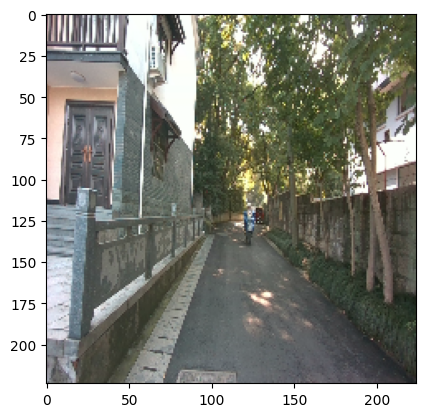

In [42]:
plt.imshow(img[0].permute(1,2,0).detach().numpy())

In [43]:
class depth_encoder(nn.Module):
    def __init__(self,in_channels = 1,out_channels = [64,128,256,512,512]):
        super().__init__()
    
        self.layer_1 = depth_CBR_2(in_channels= in_channels,out_channels= out_channels[0])
        self.layer_2 = depth_CBR_2(in_channels= out_channels[0],out_channels= out_channels[1])
        self.layer_3 = depth_CBR_3(in_channels= out_channels[1],out_channels= out_channels[2])
        self.layer_4 = depth_CBR_3(in_channels= out_channels[2],out_channels= out_channels[3])
        self.layer_5 = depth_CBR_3(in_channels= out_channels[3],out_channels= out_channels[3])


    def forward(self,x):
        skip_latent = []

        x, skip = self.layer_1(x)
        skip_latent.append(skip)
        x, skip = self.layer_2(x)
        skip_latent.append(skip)
        x, skip = self.layer_3(x)
        skip_latent.append(skip)
        x, skip = self.layer_4(x)
        skip_latent.append(skip)
        _, skip = self.layer_5(x)
        skip_latent.append(skip)

        return skip_latent

In [44]:
class image_encoder(nn.Module):
    def __init__(self,in_channels = 3,out_channels = [64,128,256,512,512]):
        super(image_encoder,self).__init__()

        self.layer_1 = image_CBR_2(in_channels= in_channels,out_channels= out_channels[0])
        self.layer_2 = image_CBR_2(in_channels= out_channels[0],out_channels= out_channels[1])

        self.layer_3 = image_CBR_3(in_channels= out_channels[1],out_channels= out_channels[2])
        self.layer_4 = image_CBR_3(in_channels= out_channels[2],out_channels= out_channels[3])
        self.layer_5 = image_CBR_3(in_channels= out_channels[3],out_channels= out_channels[3])

    def forward(self,x,skip_con):
        x = self.layer_1(x,skip_con[0])
        x = self.layer_2(x,skip_con[1])
        x = self.layer_3(x,skip_con[2])
        x = self.layer_4(x,skip_con[3])
        x = self.layer_5(x,skip_con[4])

        return x



In [45]:
depth_encoder = depth_encoder()

In [46]:
image_encoder = image_encoder()

In [47]:
skip = depth_encoder(rad)

In [48]:
img.dtype

torch.float32

In [49]:
output = image_encoder(img,skip)

In [51]:
output.shape

torch.Size([1, 512, 7, 7])